# WeakAlign demo notebook

This notebook shows how to run a trained model on a given image pair

## Imports

In [1]:
from __future__ import print_function, division
import os
import math
from os.path import exists
import argparse
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric, TwoStageCNNGeometric
from data.pf_dataset import PFDataset, PFPascalDataset
from data.download_datasets import download_PF_pascal
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict
import torch.nn.functional as F

seed = 123
gpu_id = 0
disk_dir = "/disk/scratch/s1668298/qosi/"
local_dir = "/afs/inf.ed.ac.uk/user/s16/s1668298/qosi/weakalign/"
trained_models_dir = os.path.join(disk_dir, "trained_models")
datasets_dir = os.path.join(disk_dir, "datasets")

rng = np.random.RandomState(seed)
os.environ["CUDA_VISIBLE_DEVICES"]="{0}".format(gpu_id)
warnings.filterwarnings('ignore')

## Parameters

In [2]:
# Select one of the following models:
# cnngeo_vgg16, cnngeo_resnet101, proposed_resnet101
model_selection = 'proposed_resnet101' 

model_aff_path = ''
model_tps_path = ''
model_aff_tps_path = ''

if model_selection=='cnngeo_vgg16':
    model_aff_path = os.path.join(trained_models_dir, 'cnngeo_vgg16_affine.pth.tar')
    model_tps_path = os.path.join(trained_models_dir, 'cnngeo_vgg16_tps.pth.tar')
    feature_extraction_cnn = 'vgg'
    
elif model_selection=='cnngeo_resnet101':
    model_aff_path = os.path.join(trained_models_dir, 'cnngeo_resnet101_affine.pth.tar')
    model_tps_path = os.path.join(trained_models_dir, 'cnngeo_resnet101_tps.pth.tar')   
    feature_extraction_cnn = 'resnet101'
    
elif model_selection=='proposed_resnet101':
    model_aff_tps_path = os.path.join(trained_models_dir, 'weakalign_resnet101_affine_tps.pth.tar')
    feature_extraction_cnn = 'resnet101'
    
source_image_path = os.path.join(datasets_dir, 'proposal-flow-pascal/PF-dataset-PASCAL/JPEGImages/2008_006325.jpg')
target_image_path = os.path.join(datasets_dir, 'proposal-flow-pascal/PF-dataset-PASCAL/JPEGImages/2010_004954.jpg')

if not exists(source_image_path):
    download_PF_pascal(os.path.join(datasets_dir,'proposal-flow-pascal/'))

## Load models

In [3]:
use_cuda = torch.cuda.is_available()

model = TwoStageCNNGeometric(use_cuda=use_cuda,
                             return_correlation=True,
                             feature_extraction_cnn=feature_extraction_cnn)

# load pre-trained model
if model_aff_tps_path!='':
    checkpoint = torch.load(model_aff_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
        
    for name, param in model.FeatureExtraction.state_dict().items():
        model.FeatureExtraction.state_dict()[name].copy_(checkpoint['state_dict']['FeatureExtraction.' + name])    
    for name, param in model.FeatureRegression.state_dict().items():
        model.FeatureRegression.state_dict()[name].copy_(checkpoint['state_dict']['FeatureRegression.' + name])
    for name, param in model.FeatureRegression2.state_dict().items():
        model.FeatureRegression2.state_dict()[name].copy_(checkpoint['state_dict']['FeatureRegression2.' + name])    
else:
    checkpoint_aff = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint_aff['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint_aff['state_dict'].items()])
    for name, param in model.FeatureExtraction.state_dict().items():
        model.FeatureExtraction.state_dict()[name].copy_(checkpoint_aff['state_dict']['FeatureExtraction.' + name])    
    for name, param in model.FeatureRegression.state_dict().items():
        model.FeatureRegression.state_dict()[name].copy_(checkpoint_aff['state_dict']['FeatureRegression.' + name])

    checkpoint_tps = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint_tps['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint_tps['state_dict'].items()])
    for name, param in model.FeatureRegression2.state_dict().items():
        model.FeatureRegression2.state_dict()[name].copy_(checkpoint_tps['state_dict']['FeatureRegression.' + name])

## Load and preprocess images

In [4]:
# h = 240
# w = 240
# resizeCNN = GeometricTnf(out_h=h, out_w=w, use_cuda = False) 
# normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# def preprocess_image(image):
#     # convert to torch Variable
#     image = np.expand_dims(image.transpose((2,0,1)),0)
#     image = torch.Tensor(image.astype(np.float32)/255.0)
#     image_var = Variable(image,requires_grad=False)

#     # Resize image using bilinear sampling with identity affine tnf
#     image_var = resizeCNN(image_var)
    
#     # Normalize image
#     image_var = normalize_image(image_var)
    
#     return image_var

In [5]:
# source_image = io.imread(source_image_path)
# target_image = io.imread(target_image_path)

# source_image_var = preprocess_image(source_image)
# target_image_var = preprocess_image(target_image)

# if use_cuda:
#     source_image_var = source_image_var.cuda()
#     target_image_var = target_image_var.cuda()

# batch = {'source_image': source_image_var, 'target_image':target_image_var}

# resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

## Evaluate model

In [6]:
# model.eval()

# # Evaluate model
# theta_aff,theta_aff_tps, corr_aff, corr_tps=model(batch)

# # Get initial grid C_B
# C_Bx = tpsTnf.gridGen.grid_X
# C_By = tpsTnf.gridGen.grid_Y
# initial_grid = torch.cat((C_Bx,C_By),3)  # C_B

## Quantify transform magnitude
"The dissimilarity between the two shapes is computed as a sum of matching errors between corresponding points, together with a term measuring the magnitude of the aligning transform." (Belongie et al., 2002)

![correlation](figs/correlation_fig.png)

1. **Matching error**
  * Aymmetric matching errors: $E_{m}= \frac{1}{i*j}\sum\limits_{i,j}|1 - \max\limits_{k}c_{AB}(i,j,k)|$
  * Correlation between best-matched features, averaged over the spatial locations of $f_B$
  * *Open question*: how to deal with weak / no matches? Do we expact all locations to have one strong match? Should we be counting the number of strong matches? Thresholding the correlations (match "strength")?
2. **Magnitude of the aligning transforms**
  1. **Affine**
    * $\theta_{AFF} = [a_{11}, a_{12}, a_{21}, a_{22}, t_x, t_y]$, s.t.:
    * $P_A = \begin{bmatrix}
   a_{11} & a_{12} \\
   a_{12} & a_{22}
   \end{bmatrix}P_B 
   + 
   \begin{bmatrix}
   t_x \\
   t_y
   \end{bmatrix}$
   * Magnitude: $|{\log(|\det(\Sigma)|)}| + ||\mathbf{\mu}||$, where $\Sigma = 
   \begin{bmatrix}
   a_{11} & a_{12} \\
   a_{12} & a_{22}
   \end{bmatrix}
   $ and $\mathbf{\mu} = 
   \begin{bmatrix}
   t_x \\
   t_y
   \end{bmatrix}
   $
  2. **TPS**
    * $\theta_{TPS} = [x_{C_{A1}}, \dots, x_{C_{A9}}, y_{C_{A1}}, y_{C_{A9}}]$ which maps points $P_B=[x_B, y_B]^T$ to points $P_A=[x_A, y_A]^T$:
    * Magnitude: $\sum\limits_i|\mathcal{C_{Ai}} - \mathcal{C_{Bi}}|^2$, where $\mathcal{C}_{Ai}=(x_{C_{Ai}}, y_{C_{Ai}})$ and $\mathcal{C}_{Bi}=(x_{C_{Bi}}, y_{C_{Bi}})$ 
    * Essentially, this is the square distance between the inital and final grid points, $\mathcal{C}_{B}$ and $\mathcal{C}_{A}$ respectively (shown below). This is the simplest approach -- it is possible that more could be done with the "bending energy" as in Belongie et. al (2002). However, they do not give precise details on how to compute such a bending energy.
 
 
![tps](figs/tps_fig.png)

## Compute warped images

In [7]:
# def affTpsTnf(source_image, theta_aff, theta_aff_tps, use_cuda=use_cuda, return_sampling_grid=False):
#     tpstnf = GeometricTnf(geometric_model = 'tps',use_cuda=use_cuda)
#     sampling_grid = tpstnf(image_batch=source_image,
#                            theta_batch=theta_aff_tps,
#                            return_sampling_grid=True)[1]
#     X = sampling_grid[:,:,:,0].unsqueeze(3)
#     Y = sampling_grid[:,:,:,1].unsqueeze(3)
#     Xp = X*theta_aff[:,0].unsqueeze(1).unsqueeze(2)+Y*theta_aff[:,1].unsqueeze(1).unsqueeze(2)+theta_aff[:,2].unsqueeze(1).unsqueeze(2)
#     Yp = X*theta_aff[:,3].unsqueeze(1).unsqueeze(2)+Y*theta_aff[:,4].unsqueeze(1).unsqueeze(2)+theta_aff[:,5].unsqueeze(1).unsqueeze(2)
#     sg = torch.cat((Xp,Yp),3)
#     warped_image_batch = F.grid_sample(source_image, sg)
    
#     if return_sampling_grid:
#         return warped_image_batch, sampling_grid

#     return warped_image_batch

# # Original way: aff, then aff + tps on source
# warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3), return_sampling_grid=True)
# warped_image_aff_tps_joint, joint_grid = affTpsTnf(batch['source_image'],theta_aff,theta_aff_tps, return_sampling_grid=True)

# # New, one-at-a-time way
# warped_image_aff, aff_grid = affTnf(batch['source_image'],theta_aff.view(-1,2,3), return_sampling_grid=True)
# warped_image_aff_tps, tps_grid = tpsTnf(warped_image_aff, theta_aff_tps, return_sampling_grid=True)

## Display

## Calculate magnitudes

In [13]:
h = 240
w = 240


# Simplest method: calculate distance moved by each transform (aff, tps)
def d_pA_pB(pA, pB):
    "Distance move for a single sample (image)"
    deltas = (pB - pA)**2
    deltas[:, :, 0] = deltas[:, :, 0] / float(w**2)
    deltas[:, :, 1] = deltas[:, :, 1] / float(h**2)
    d2s = np.sum(deltas, axis=2)
    ds = np.sqrt(d2s)
    return np.sum(ds)

def d_pA_pB_batch(pAs, pBs):
    "Distance moved for a batch of samples (images)"
    ds = []
    for pA, pB in zip(pAs, pBs):
        ds.append(d_pA_pB(pA, pB))
    return np.array(ds)


# More fine-grained method
def d_aff_direct(S, m):
    """ S, m map coordinates from the target image B to the source image A """
    n = float(S.shape[0])  # nxn matrix
    S_det = np.linalg.det(S)
    S_rot = S * S_det**(-1./n)  # matrix whose det=1 --> is this necessarily a rotation matrix?
    theta = math.acos((np.trace(S_rot) - 1.) / 2.) * 180. / math.pi  # rotation angle in degrees
    print(1. / S_det)
    print(S_det)
    scale = np.log(abs(1. / S_det)) / np.log(10)  # target to source transformation!
    pos = np.sqrt(m.dot(m.T))
    return theta, scale, pos

def d_aff_direct_batch(Sigma, mu):
    "Batch version"
    ds_sc_rot = []
    ds_pos = []
    for S, m in zip(Sigma, mu):        
        # Compute distances   
        d_sc_rot, d_pos = d_aff_direct(S, m)        
        ds_sc_rot.append(d_sc_rot)
        ds_pos.append(d_pos)
    return np.array(ds_sc_rot), np.array(ds_pos)

tensor(1.00000e-03 *
       [[ 4.6018,  4.5674,  4.5449,  4.5234,  4.5170,  4.5257,  4.5184,
          4.5054,  4.4983,  4.5290,  4.5323,  4.5165,  4.5307,  4.5649,
          4.5947],
        [ 4.5316,  4.5571,  4.5457,  4.5370,  4.5362,  4.5298,  4.5245,
          4.5157,  4.5194,  4.5277,  4.5385,  4.5400,  4.5406,  4.5515,
          4.5548],
        [ 4.5373,  4.5189,  4.5128,  4.4927,  4.4855,  4.4840,  4.4786,
          4.4849,  4.4913,  4.4879,  4.4854,  4.4776,  4.4784,  4.4971,
          4.4946],
        [ 4.4996,  4.5295,  4.5080,  4.4930,  4.4756,  4.4844,  4.4725,
          4.4740,  4.4934,  4.4782,  4.4692,  4.4734,  4.4699,  4.4803,
          4.4730],
        [ 4.4884,  4.4933,  4.4781,  4.4808,  4.4817,  4.4829,  4.4734,
          4.4752,  4.4810,  4.4739,  4.4724,  4.4719,  4.4729,  4.4761,
          4.4676],
        [ 4.4842,  4.4862,  4.4776,  4.4780,  4.4749,  4.4969,  4.4703,
          4.4708,  4.4711,  4.4729,  4.4604,  4.4664,  4.4846,  4.4683,
          4.4654],
 

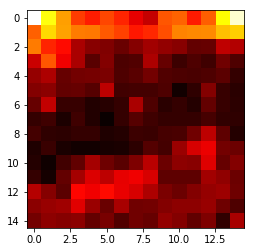

1.6477278452599486
0.60689634


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Showing results. Close figure window to continue


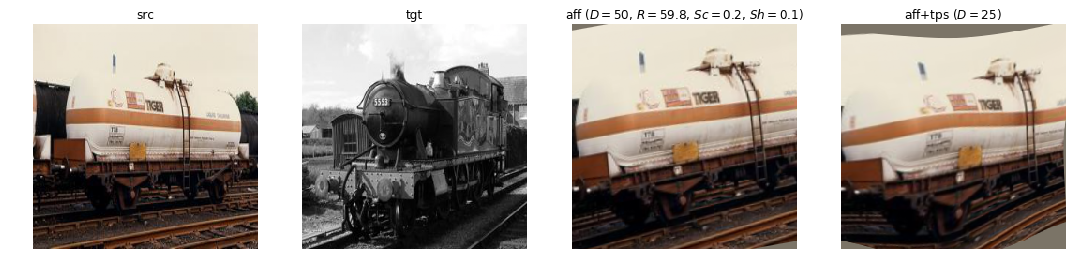

Process Process-88:
Process Process-86:
Process Process-85:
Process Process-87:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/afs/inf.ed.ac.uk/u

KeyboardInterrupt: 

  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/afs/inf.ed.ac.uk/user/s16/s1668298/miniconda3/envs/gof/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/afs/inf.ed.ac.uk/u

In [31]:
%matplotlib inline

# Dataset and dataloader
pf_path = os.path.join(datasets_dir, 'proposal-flow-pascal')
dataset = PFPascalDataset(csv_file=os.path.join(pf_path, 'test_pairs_pf_pascal.csv'),
                          dataset_path=pf_path,
                          transform=NormalizeImageDict(['source_image','target_image']))
dataloader = DataLoader(dataset, batch_size=1,
                        shuffle=True, num_workers=4)
batchTensorToVars = BatchTensorToVars(use_cuda=use_cuda)


# Instatiate image transformers
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)
tpsTnf = GeometricTnf(geometric_model = 'tps',use_cuda=use_cuda)

# Get initial grid [-1,1]
grid_x = tpsTnf.gridGen.grid_X
grid_y = tpsTnf.gridGen.grid_Y
initial_grid = torch.cat((grid_x,grid_y),3)

for i, batch in enumerate(dataloader):
    # get random batch of size 1
    batch = batchTensorToVars(batch)
    
    source_im_size = batch['source_im_size']
    target_im_size = batch['target_im_size']

    source_points = batch['source_points']
    target_points = batch['target_points']
    
    # warp points with estimated transformations
    target_points_norm = PointsToUnitCoords(target_points,target_im_size)
    
    model.eval()
    
    # Evaluate model
    theta_aff,theta_aff_tps, corr_aff, corr_tps=model(batch)
    sm = torch.nn.functional.softmax(corr_aff**2, dim=1)[0]
    m = torch.max(sm, dim=0)[0]
    print(m)
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.show()
    
    # Apply warps to image and grid    
    warped_image_aff, aff_grid = affTnf(batch['source_image'],theta_aff.view(-1,2,3), return_sampling_grid=True)
    warped_image_aff_tps, tps_grid = tpsTnf(warped_image_aff, theta_aff_tps, return_sampling_grid=True)
    
    # Calculate warp magnitudes
    # --Distances     
    pA = initial_grid.detach().cpu().numpy()[0]
    pA_aff = aff_grid.detach().cpu().numpy()[0]
    pA_tps = tps_grid.detach().cpu().numpy()[0]
    D_aff = d_pA_pB(pA, pA_aff)
    D_tps = d_pA_pB(pA, pA_tps)
    
    # --Affine directly (separate errors for shift and linear tranform)
    theta_aff = theta_aff.view(-1,2,3).detach().cpu().numpy()
    Sigma = theta_aff[:, :, :2][0]
    mu = theta_aff[:,:,2][0].T
    rot, scale, shift = d_aff_direct(Sigma, mu)

    # Un-normalize images and convert to numpy
    source_image = normalize_image(batch['source_image'],forward=False)
    source_image = source_image.data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    target_image = normalize_image(batch['target_image'],forward=False)
    target_image = target_image.data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    
    warped_image_aff = normalize_image(warped_image_aff,forward=False)
    warped_image_aff = warped_image_aff.data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

    warped_image_aff_tps = normalize_image(warped_image_aff_tps,forward=False)
    warped_image_aff_tps = warped_image_aff_tps.data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

    # check if display is available
    exit_val = os.system('python -c "import matplotlib.pyplot as plt;plt.figure()"  > /dev/null 2>&1')
    display_avail = exit_val==0

    if display_avail:
        N_subplots = 4
        fig, axs = plt.subplots(1,N_subplots)
        fig.set_size_inches(18.5, 10.5)
        axs[0].imshow(source_image)
        axs[0].set_title('src')
        axs[1].imshow(target_image)
        axs[1].set_title('tgt')
        axs[2].imshow(warped_image_aff)
        axs[2].set_title('aff ($D={0}$, $R={1:.1f}$, $Sc={2:.1f}$, $Sh={3:.1f}$)'.format(int(D_aff), rot, scale, shift))
        axs[3].imshow(warped_image_aff_tps)
        axs[3].set_title('aff+tps ($D={0}$)'.format(int(D_tps)))
    
        for i in range(N_subplots):
            axs[i].axis('off')
        print('Showing results. Close figure window to continue')
        plt.show()
    else:
        print('No display found. Writing results to:')
        fn_src = 'source.png'
        print(fn_src)
        io.imsave(fn_src, source_image)
        fn_tgt = 'target.png'
        print(fn_tgt)
        io.imsave(fn_tgt, target_image)
        fn_aff = 'result_aff.png'
        print(fn_aff)
        io.imsave(fn_aff, warped_image_aff)
        fn_aff_tps = 'result_aff_tps.png'
        print(fn_aff_tps)
        io.imsave(fn_aff_tps,warped_image_aff_tps)
    
    res = input('Run for another example ([y]/n): ')
    if res=='n':
        break
